In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Generating Names with a Character-Level RNN
=============================================================

**Author**: [Sean Robertson](https://github.com/spro)

This tutorials is part of a three-part series:

-   [NLP From Scratch: Classifying Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
-   [NLP From Scratch: Generating Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
-   [NLP From Scratch: Translation with a Sequence to Sequence Network
    and
    Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

This is our second of three tutorials on \"NLP From Scratch\". In the
[first
tutorial](/tutorials/intermediate/char_rnn_classification_tutorial) we
used a RNN to classify names into their language of origin. This time
we\'ll turn around and generate names from languages.

``` {.sh}
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a \"language model\".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

I also suggest the previous tutorial,
`/intermediate/char_rnn_classification_tutorial`{.interpreted-text
role="doc"}

Preparing the Data
------------------

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>

</div>

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files `data/names/[Language].txt` with a name
per line. We split lines into an array, convert Unicode to ASCII, and
end up with a dictionary `{language: [names ...]}`.


In [6]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Polish', 'Portuguese', 'Japanese', 'Korean', 'Spanish', 'Scottish', 'Vietnamese', 'Irish', 'German', 'French', 'Greek', 'Italian', 'Russian', 'Chinese', 'Arabic', 'Dutch', 'Czech', 'English']
O'Neal


Creating the Network
====================

This network extends [the last tutorial\'s RNN](#Creating-the-Network)
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer `o2o` (after combining hidden and output)
to give it more muscle to work with. There\'s also a dropout layer,
which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580) with a given probability (here
0.1) and is usually used to fuzz inputs to prevent overfitting. Here
we\'re using it towards the end of the network to purposely add some
chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)


In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
========

Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):


In [8]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be `(category, current letter, hidden state)`
and the outputs will be `(next letter, next hidden state)`. So for each
training set, we\'ll need the category, a set of input letters, and a
set of output/target letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for `"ABCD<EOS>"` we would create (\"A\", \"B\"), (\"B\",
\"C\"), (\"C\", \"D\"), (\"D\", \"EOS\").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot) of size
`<1 x n_categories>`. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.


In [9]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we\'ll make a `randomTrainingExample`
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.


In [10]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
====================

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.


In [11]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
`timeSince(timestamp)` function which returns a human readable string:


In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every `print_every`
examples, and keeping store of an average loss per `plot_every` examples
in `all_losses` for plotting later.


In [13]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 21s (5000 5%) 3.5963
0m 39s (10000 10%) 2.6133
0m 57s (15000 15%) 2.5748
1m 16s (20000 20%) 2.4237
1m 34s (25000 25%) 3.0846
1m 52s (30000 30%) 2.8703
2m 11s (35000 35%) 2.6383
2m 29s (40000 40%) 2.9602
2m 47s (45000 45%) 2.0099
3m 5s (50000 50%) 2.6641
3m 23s (55000 55%) 2.1376
3m 41s (60000 60%) 2.5203
4m 0s (65000 65%) 2.7707
4m 19s (70000 70%) 3.4601
4m 37s (75000 75%) 2.9104
4m 55s (80000 80%) 2.1221
5m 14s (85000 85%) 2.3285
5m 31s (90000 90%) 2.4896
5m 49s (95000 95%) 3.2461
6m 8s (100000 100%) 1.1572


Plotting the Losses
===================

Plotting the historical loss from all\_losses shows the network
learning:


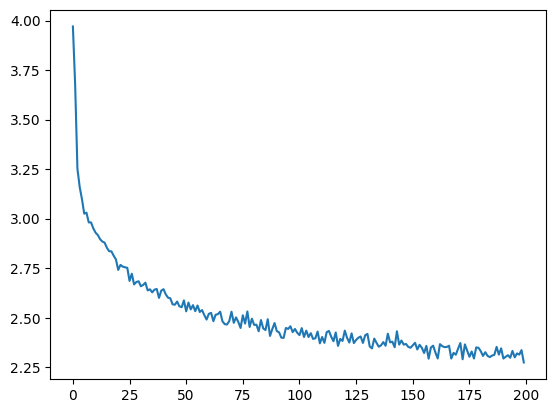

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-   Create tensors for input category, starting letter, and empty hidden
    state
-   Create a string `output_name` with the starting letter
-   Up to a maximum output length,
    -   Feed the current letter to the network
    -   Get the next letter from highest output, and next hidden state
    -   If the letter is EOS, stop here
    -   If a regular letter, add to `output_name` and continue
-   Return the final name

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Rather than having to give it a starting letter, anotherstrategy would have been to include a "start of string" token intraining and have the network choose its own starting letter.</p>

</div>



In [15]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roukans
Uarikov
Sakinav
Garer
Eerten
Remer
Saller
Pora
Alaner
Chin
Han
Iun


Exercises
=========

-   Try with a different dataset of category -\> line, for example:
    -   Fictional series -\> Character name
    -   Part of speech -\> Word
    -   Country -\> City
-   Use a \"start of sentence\" token so that sampling can be done
    without choosing a start letter
-   Get better results with a bigger and/or better shaped network
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network


##First point


In [20]:
import json
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt

# Provided code functions and variables
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# --- Data Loading and Preparation (Adapted) ---

# Load data from character_codex.json
try:
    with open('/content/drive/MyDrive/character_codex.json', 'r', encoding='utf-8') as f:
        character_data = json.load(f)
except FileNotFoundError:
    print("Error: character_codex.json not found. Please ensure the file is in the same directory.")
    character_data = []

# Build the category_lines dictionary: 'media_source' as category, list of 'character_name' as lines
category_lines = {}
for entry in character_data:
    category = entry.get('media_source')
    line = entry.get('character_name')
    if category and line:
        if category not in category_lines:
            category_lines[category] = []
        processed_line = unicodeToAscii(line.strip())
        if processed_line: # Only add non-empty lines after processing
            category_lines[category].append(processed_line)


all_categories = list(category_lines.keys())
n_categories = len(all_categories)

# Remove categories with no lines after processing
categories_to_remove = [cat for cat in all_categories if not category_lines[cat]]
for cat in categories_to_remove:
    all_categories.remove(cat)
    del category_lines[cat]

n_categories = len(all_categories) # Update n_categories after removing empty ones


if n_categories == 0:
    raise RuntimeError('Data not found or failed to process. Check character_codex.json and ensure it has "media_source" and "character_name" fields with valid data.')

print('# categories:', n_categories, all_categories)
if all_categories:
    print(f"Приклад даних для категорії '{all_categories[0]}': {category_lines[all_categories[0]][:5]}...")

# categories: 9061 ['Saga', 'The Smiling, Proud Wanderer', 'Atomic Robo', 'Fairy Tail', "Maus: A Survivor's Tale", 'Uncertainty Principle', 'The Adventures of Tintin', 'Historical Scientist', 'Marvel Comics', 'Demon Slayer (Kimetsu no Yaiba)', 'DC Comics', 'Hand Maid May', 'The Seagull by Anton Chekhov', 'The Ravages of Time', 'Barefoot Contessa', 'Streets of Rage', 'The Picture of Dorian Gray', 'Narcos', 'New Jersey Folklore', 'Clannad', 'The Legend of Zelda: Breath of the Wild Board Game', 'The Lord of the Rings', 'Biography Magazine', 'Devilman Crybaby', 'Mindful Health Journal', 'Renaissance History', 'Spider-Man / Marvel Comics', 'Harold and the Purple Crayon', 'XXL', 'House of Cards', 'Kid Icarus', "Zlata's Diary: A Child's Life in Wartime Sarajevo", 'Akame ga Kill!', "Assassin's Creed Origins", 'Candy Crush Friends Saga', 'Saw', 'Ode to Billie Joe by Bobbie Gentry', 'Person of Interest', 'Final Fantasy VII', 'English Folklore', 'Bookworm', 'The Sarah Silverman Program', 'Inuyash

In [21]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [22]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [24]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


Starting training...
4m 22s (5000 5%) 3.4832
8m 37s (10000 10%) 3.2484
12m 51s (15000 15%) 2.5518
17m 4s (20000 20%) 2.4251
21m 15s (25000 25%) 2.4089
25m 20s (30000 30%) 2.6713
29m 21s (35000 35%) 2.6728
33m 20s (40000 40%) 2.9444
37m 23s (45000 45%) 3.1703
41m 26s (50000 50%) 2.5347
45m 27s (55000 55%) 2.6559
49m 33s (60000 60%) 2.5027
53m 40s (65000 65%) 2.9447
57m 47s (70000 70%) 2.6992
62m 4s (75000 75%) 2.9470
66m 28s (80000 80%) 2.7839
70m 49s (85000 85%) 1.9591
75m 15s (90000 90%) 2.5151
79m 37s (95000 95%) 3.1151
83m 58s (100000 100%) 2.4480


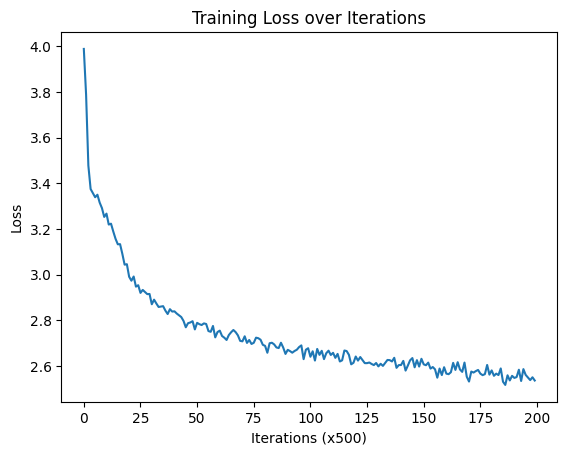

In [25]:
# Initialize the RNN model
rnn = RNN(n_letters, 128, n_letters)

# --- Training loop ---
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

print("\nStarting training...")
try:
    for iter in range(1, n_iters + 1):
        output, loss = train(*randomTrainingExample())
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

    # Plotting the loss
    plt.figure()
    plt.plot(all_losses)
    plt.xlabel("Iterations (x500)")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.show()

except RuntimeError as e:
    print(f"\nRuntime Error during training: {e}")
    print("Ensure you have a suitable environment with PyTorch and CUDA support if needed.")
except Exception as e:
     print(f"\nAn unexpected error occurred during training: {e}")


In [26]:
# --- Sampling ---
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print("\nAttempting to sample names:")
if all_categories:
    try:
        # Sample from a few categories
        for cat in all_categories[:min(len(all_categories), 3)]: # Sample from up to 3 categories
            print(f"\nCategory: {cat}")
            samples(cat, 'ABC')
    except Exception as e:
        print(f"\nError during sampling: {e}")
        print("This might be related to training issues or environment setup.")
else:
    print("No categories found to sample from.")


Attempting to sample names:

Category: Saga
Allin Bard
Berte Brang
Carin Barde

Category: The Smiling, Proud Wanderer
Allin Barder
Baris Bande
Cante Brande

Category: Atomic Robo
Allin Barde
Baris Carte
Caris Bonge


##Second point


In [2]:
import json
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt

In [3]:
# Provided code functions and variables
all_letters = string.ascii_letters + " .,;'-"

# Define SOS and EOS tokens and update n_letters
SOS_token = len(all_letters)
EOS_token = len(all_letters) + 1
n_letters = len(all_letters) + 2 # Plus SOS and EOS markers

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters # Only include characters in our defined set
    )

# Helper to find index of a letter
def letterToIndex(letter):
    return all_letters.find(letter)

# Helper to find index of SOS or EOS
def tokenToIndex(token):
    if token == 'SOS':
        return SOS_token
    elif token == 'EOS':
        return EOS_token
    else:
        raise ValueError("Unknown token")

In [4]:
# Load data from character_codex.json
try:
    with open('/content/drive/MyDrive/character_codex.json', 'r', encoding='utf-8') as f:
        character_data = json.load(f)
except FileNotFoundError:
    print("Error: character_codex.json not found. Please ensure the file is in the same directory.")
    character_data = []

# Build the category_lines dictionary: 'media_source' as category, list of 'character_name' as lines
category_lines = {}
for entry in character_data:
    category = entry.get('media_source')
    line = entry.get('character_name')
    if category and line:
        if category not in category_lines:
            category_lines[category] = []
        processed_line = unicodeToAscii(line.strip())
        if processed_line: # Only add non-empty lines after processing
            category_lines[category].append(processed_line)


all_categories = list(category_lines.keys())
n_categories = len(all_categories)

# Remove categories with no lines after processing
categories_to_remove = [cat for cat in all_categories if not category_lines[cat]]
for cat in categories_to_remove:
    all_categories.remove(cat)
    del category_lines[cat]

n_categories = len(all_categories) # Update n_categories after removing empty ones


if n_categories == 0:
    raise RuntimeError('Data not found or failed to process. Check character_codex.json and ensure it has "media_source" and "character_name" fields with valid data.')

print('# categories:', n_categories, all_categories)
if all_categories:
    print(f"Приклад даних для категорії '{all_categories[0]}': {category_lines[all_categories[0]][:5]}...")



# categories: 9061 ['Saga', 'The Smiling, Proud Wanderer', 'Atomic Robo', 'Fairy Tail', "Maus: A Survivor's Tale", 'Uncertainty Principle', 'The Adventures of Tintin', 'Historical Scientist', 'Marvel Comics', 'Demon Slayer (Kimetsu no Yaiba)', 'DC Comics', 'Hand Maid May', 'The Seagull by Anton Chekhov', 'The Ravages of Time', 'Barefoot Contessa', 'Streets of Rage', 'The Picture of Dorian Gray', 'Narcos', 'New Jersey Folklore', 'Clannad', 'The Legend of Zelda: Breath of the Wild Board Game', 'The Lord of the Rings', 'Biography Magazine', 'Devilman Crybaby', 'Mindful Health Journal', 'Renaissance History', 'Spider-Man / Marvel Comics', 'Harold and the Purple Crayon', 'XXL', 'House of Cards', 'Kid Icarus', "Zlata's Diary: A Child's Life in Wartime Sarajevo", 'Akame ga Kill!', "Assassin's Creed Origins", 'Candy Crush Friends Saga', 'Saw', 'Ode to Billie Joe by Bobbie Gentry', 'Person of Interest', 'Final Fantasy VII', 'English Folklore', 'Bookworm', 'The Sarah Silverman Program', 'Inuyash

In [5]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of SOS token + first to last letters for input
def inputTensor(line):
    tensor = torch.zeros(len(line) + 1, 1, n_letters)
    tensor[0][0][SOS_token] = 1 # SOS token at the beginning
    for li in range(len(line)):
        letter = line[li]
        tensor[li + 1][0][letterToIndex(letter)] = 1
    return tensor

# ``LongTensor`` of first letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [letterToIndex(line[li]) for li in range(len(line))]
    letter_indexes.append(EOS_token) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    # Iterate through the input sequence (SOS + letters)
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        # Target is the next token in the sequence (first letter after SOS, then subsequent letters, then EOS)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Initialize the RNN model
rnn = RNN(n_letters, 128, n_letters)


Starting training...
3m 0s (5000 5%) 3.1335
6m 0s (10000 10%) 3.1446
9m 1s (15000 15%) 2.8370
12m 5s (20000 20%) 2.6504
15m 10s (25000 25%) 3.2007
18m 14s (30000 30%) 2.6980
21m 22s (35000 35%) 2.6341
24m 30s (40000 40%) 2.6185
27m 42s (45000 45%) 2.5549
30m 57s (50000 50%) 2.7616
34m 11s (55000 55%) 2.3438
37m 27s (60000 60%) 2.9089
40m 43s (65000 65%) 3.1635
43m 50s (70000 70%) 2.1324
46m 54s (75000 75%) 3.0710
49m 58s (80000 80%) 2.8595
53m 0s (85000 85%) 2.3545
56m 14s (90000 90%) 2.4393
59m 29s (95000 95%) 2.3613
62m 44s (100000 100%) 2.2000


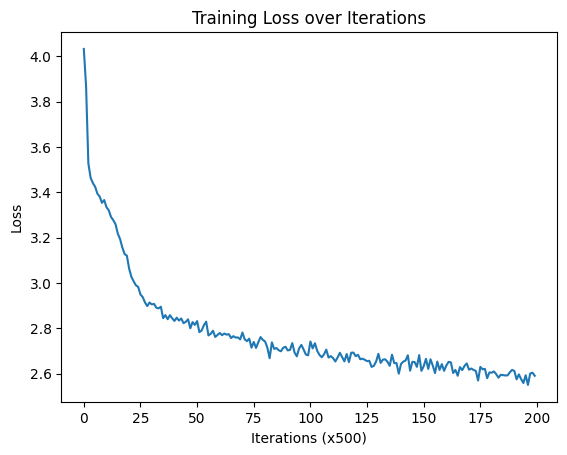

In [8]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

print("\nStarting training...")
try:
    for iter in range(1, n_iters + 1):
        output, loss = train(*randomTrainingExample())
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

    # Plotting the loss
    plt.figure()
    plt.plot(all_losses)
    plt.xlabel("Iterations (x500)")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.show()

except RuntimeError as e:
    print(f"\nRuntime Error during training: {e}")
    print("Ensure you have a suitable environment with PyTorch and CUDA support if needed.")
except Exception as e:
     print(f"\nAn unexpected error occurred during training: {e}")



In [9]:
max_length = 20

def sample(category): # No start_letter needed now
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)

        # Start with the SOS token
        input = torch.zeros(1, 1, n_letters)
        input[0][0][SOS_token] = 1

        hidden = rnn.initHidden()

        output_name = ''

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]

            if topi == EOS_token:
                break
            else:
                # Get the letter from the predicted index
                letter = all_letters[topi]
                output_name += letter
                # Use the predicted letter as the next input
                input = torch.zeros(1, 1, n_letters)
                input[0][0][topi] = 1

        return output_name

# Get multiple samples from one category (no start letters needed)
def samples(category, num_samples=3):
    print(f"\nGenerating {num_samples} samples for category '{category}':")
    for i in range(num_samples):
        print(sample(category))

print("\nAttempting to sample names:")
if all_categories:
    try:
        # Sample from a few categories
        for cat in all_categories[:min(len(all_categories), 3)]: # Sample from up to 3 categories
            samples(cat)
    except Exception as e:
        print(f"\nError during sampling: {e}")
        print("This might be related to training issues or environment setup.")
else:
    print("No categories found to sample from.")


Attempting to sample names:

Generating 3 samples for category 'Saga':
The Brander Mand
The Barder
The Barder

Generating 3 samples for category 'The Smiling, Proud Wanderer':
The Barder
The Barter
The Barder Mard

Generating 3 samples for category 'Atomic Robo':
The Stone Bran
The Bander
The Berter Mord
